# DSSC geometry

The DSSC detector used at SCS consists of 16 modules of 128×512 pixels each.
Each module consists of two tiles.

In [1]:
%matplotlib inline
from extra_geom import DSSC_1MGeometry

We can generate a simple geometry from (x, y) coordinates of the bottom, beam-right (right looking along the beam) corner of each quadrant:

<AxesSubplot:title={'center':'DSSC detector geometry (No file)'}, xlabel='pixels', ylabel='pixels'>

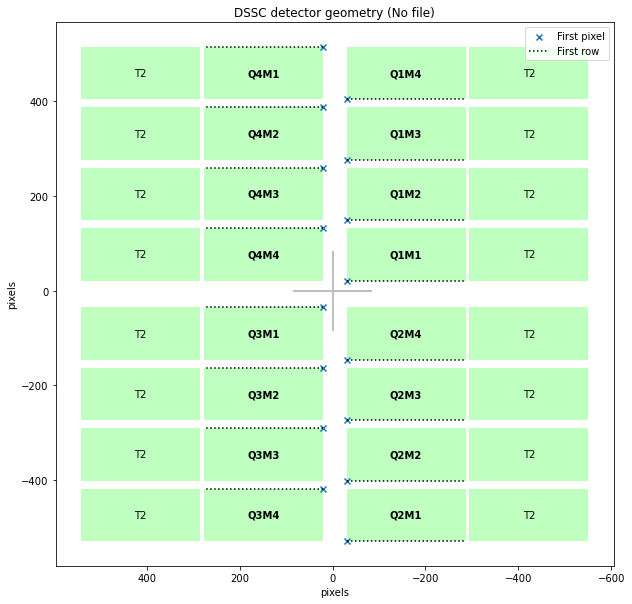

In [2]:
# Made up numbers!
quad_pos = [
    (-130, 5),
    (-130, -125),
    (5, -125),
    (5, 5),
]

g = DSSC_1MGeometry.from_quad_positions(quad_pos)
g.inspect()

We can also load geometry information for DSSC from an EuXFEL HDF5 geometry file.
These files do not store the quadrant positions, so we need to use it along with the quadrant
positions, in the same format as above.

<AxesSubplot:title={'center':'DSSC detector geometry (dssc_geo_june19.h5)'}, xlabel='pixels', ylabel='pixels'>

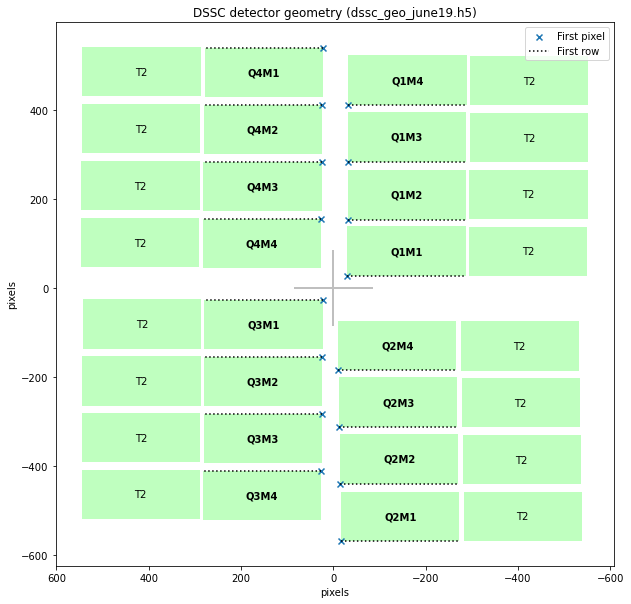

In [3]:
g2 = DSSC_1MGeometry.from_h5_file_and_quad_positions('dssc_geo_june19.h5', quad_pos)
g2.inspect()

The code above creates a geometry object for DSSC.
See these examples for how to use a geometry object:

- [Assemble images](apply_geometry.ipynb)
- [Create masks](masks.ipynb)

## Hexagonal pixels

DSSC has unusual hexagonal pixels. Assembling an image treats the pixels as uniform rectangles so that one input pixel is one output pixel, but the geometry object does know about the real shape and layout of the pixels.

Let's have a close up look at some pixels in Q1M1. `get_pixel_positions()` gives us pixel centres.
`to_distortion_array()` gives pixel corners in a slightly different format, suitable for [PyFAI](https://pyfai.readthedocs.io/en/master/).

PyFAI requires non-negative x and y coordinates. But we want to plot them along with the centre positions, so we pass `allow_negative_xy=True` to get comparable coordinates.

In [4]:
pixel_pos = g2.get_pixel_positions()
print("Pixel positions array shape:", pixel_pos.shape,
      "= (modules, slow_scan, fast_scan, x/y/z)")
q1m1_centres = pixel_pos[0]
cx = q1m1_centres[..., 0]
cy = q1m1_centres[..., 1]

distortn = g2.to_distortion_array(allow_negative_xy=True)
print("Distortion array shape:", distortn.shape,
      "= (modules * slow_scan, fast_scan, corners, z/y/x)")
q1m1_corners = distortn[:128]

Pixel positions array shape: (16, 128, 512, 3) = (modules, slow_scan, fast_scan, x/y/z)
Distortion array shape: (2048, 512, 6, 3) = (modules * slow_scan, fast_scan, corners, z/y/x)


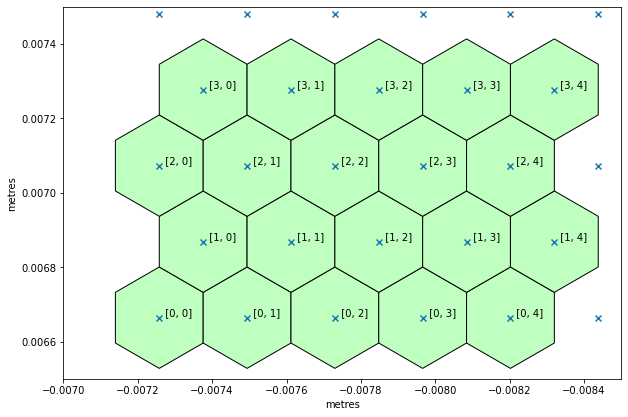

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(10, 10))

hexes = []
for ss_pxl in range(4):
    for fs_pxl in range(5):
        
        # Create hexagon
        corners = q1m1_corners[ss_pxl, fs_pxl]
        corners = corners[:, 1:][:, ::-1]  # Drop z, flip x & y
        hexes.append(Polygon(corners))
        
        # Draw text label near the pixel centre
        ax.text(cx[ss_pxl, fs_pxl], cy[ss_pxl, fs_pxl],
                '  [{}, {}]'.format(ss_pxl, fs_pxl),
                verticalalignment='bottom', horizontalalignment='left')

# Add the hexagons to the plot
pc = PatchCollection(hexes, facecolor=(0.75, 1.0, 0.75), edgecolor='k')
ax.add_collection(pc)

# Plot the pixel centres
ax.scatter(cx[:5, :6], cy[:5, :6], marker='x')

# matplotlib is reluctant to show such a small area, so we need to set the limits manually
ax.set_xlim(-0.007, -0.0085)  # To match the convention elsewhere, draw x right-to-left
ax.set_ylim(0.0065, 0.0075)
ax.set_ylabel("metres")
ax.set_xlabel("metres")
ax.set_aspect(1)

Every second row of pixels is offset half a pixel width relative to its neighbours.